# Continuous Control (Using the DDPG Algorithm)

---

You are welcome to use this coding environment to train your agent for the project. Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
!pip -q install torchviz

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
# Imports.
import time
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# High-resolution plots for retina displays.
%config InlineBackend.figure_format = 'retina'

# Utility imports.
from itertools import count
from collections import deque
from torch.autograd import Variable
# from torch import nn
from torchviz import make_dot, make_dot_from_trace

# Hide any deprecate warnings.
import warnings
warnings.filterwarnings("ignore")

# Agents interact with, and learns from environments.
from agent import Agent
from model import Actor, Critic

%load_ext autoreload
%autoreload 2

In [4]:
# Unity environment.
from unityagents import UnityEnvironment

# Select this option to load version 1 (with a single agent) of the environment.
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# Select this option to load version 2 (with 20 agents) of the environment.
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# Get the default brain.
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#### Obtain NVidia GPU information

In [6]:
# Set the working device on the NVIDIA Tesla K80 accelerator GPU (depending on availability).
# Otherwise we use the CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', str(device).upper())
print()

# Log additional info (when using the NVIDIA Tesla K80 accelerator).
# See <https://www.nvidia.com/en-gb/data-center/tesla-k80/>.
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: CUDA

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# Reset the environment.
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents.
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# Size of each action.
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Examine the state space.
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [8]:
env_info = env.reset(train_mode=True)[brain_name]      # Reset the environment.
states = env_info.vector_observations                  # Get the current state (for each agent).
scores = np.zeros(num_agents)                          # Initialize the score (for each agent).
while True:
    actions = np.random.randn(num_agents, action_size) # Select an action (for each agent).
    actions = np.clip(actions, -1, 1)                  # All actions between -1 and 1.
    env_info = env.step(actions)[brain_name]           # Send all actions to tne environment.
    next_states = env_info.vector_observations         # Get next state (for each agent).
    rewards = env_info.rewards                         # Get reward (for each agent).
    dones = env_info.local_done                        # See if episode finished.
    scores += env_info.rewards                         # Update the score (for each agent).
    states = next_states                               # Roll over states to next time step.
    if np.any(dones):                                  # Exit loop if episode finished.
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1254999971948564


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

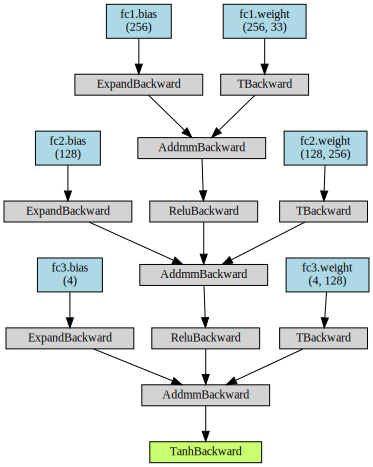

In [8]:
critic = Critic(state_size, action_size, 0)
x = Variable(torch.randn(1, state_size))
z = Variable(torch.randn(1, action_size))
y = critic(x, z)
dot = make_dot(y, params=dict(list(critic.named_parameters())))
print(dot)
dot.format = 'png'
dot.render("Critic")

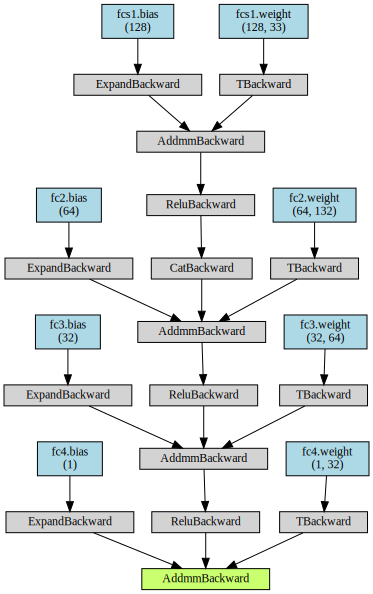

In [9]:
critic = Critic(state_size, action_size, 42)
x = Variable(torch.randn(1, state_size))
z = Variable(torch.randn(1, action_size))
y = critic(x, z)
             
make_dot(y, params=dict(list(critic.named_parameters())))

#### Define the Training Function

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [12]:
def ddpg(n_episodes=int(1e3), max_t=int(1e3)):
    """ Implementation of the Deep Deterministic Policy Gradient (DDPG) algorithm.
        See <https://spinningup.openai.com/en/latest/algorithms/ddpg.html>.
    
    Params
    ======
        n_episodes (int): Maximum number of training episodes
        max_t (int): Maximum number of time steps per episode
    """
    
    scores = []            # List containing scores from each episode.
    best_score = 0.        # Reference to the best score achievable (i.e. should be >= 30.0).
    best_avg_score = 0.    # Best average score achievable (i.e. should be >= 30.0).
    scores_mean = deque(maxlen=int(1e2))                     # List of score means.
    mean = []              # List the mean of the window scores.
    
    # Initialize, and add new agents.
    for i_episode in range(1, n_episodes+1):
        avg_score = 0.
        env_info = env.reset(train_mode=True)[brain_name]    # Reset the environment.
        states = env_info.vector_observations                # Get the current state (for each agent).
        scores_window = np.zeros(num_agents)                 # Initialize the score (for each agent).
        score = 0.                                           # Current score.
        agent.reset()                                        # Reset each agent (and noise).
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]         # Send all actions to tne environment.
            next_states = env_info.vector_observations       # Get next state (for each agent).
            rewards = env_info.rewards                       # Get reward (for each agent).
            dones = env_info.local_done                      # See if episode finished.
            
            # Update the score (for each agent).
            agent.step(t, states, actions, rewards, next_states, dones)
            
            states = next_states                             # Roll over states to the next time step.
            scores_window += rewards
            
            if np.any(dones):                                # Exit loop if the episode finished.
                break
        
        score = np.mean(scores_window)                       # Save the most recent score.
        scores_mean.append(score)
        avg_score = np.mean(scores_mean)                     # Save the most recent average score.
        scores.append(score)
        mean.append(avg_score)                               # Add this average score to the means list.
        
        if score > best_score:                               # Is this the best score?
            best_score = score
        if avg_score > best_avg_score:                       # Is this the best average score?
            best_avg_score = avg_score

        print('\rEP {}\tMIN: {:.2f}\tMAX: {:.2f}\tSCORE: {:.2f}\tBEST: {:.2f}\tAVG: {:.2f}\tBEST AVG: {:.2f}'.format(
            i_episode,
            scores_window.min(),
            scores_window.max(),
            score,
            best_score,
            avg_score,
            best_avg_score), end="\n")
        
        if avg_score >= 30.:
            print('\nEnvironment solved in {:d} episodes.\tAverage score (μ): {:.2f}'.format(
                i_episode-100, avg_score), end="\n")
            torch.save(agent.actor_local.state_dict(), 'models/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'models/checkpoint_critic.pth')
            print("\nModels saved successfully.")        
            break

    # Return the scores.
    return scores, mean

#### Create and Train the Agent

In [13]:
# Monitor training time (start time).
start_time = time.time()

# Now, we train the agent.
scores, mean = ddpg()

# Monitor training time (end time).
end_time = (time.time()-start_time)/6e1

# Log the runtime.
print("\nTotal runtime {:.2f} minutes.".format(end_time))

EP 1	MIN: 0.00	MAX: 0.94	SCORE: 0.33	BEST: 0.33	AVG: 0.33	BEST AVG: 0.33
EP 2	MIN: 0.00	MAX: 0.32	SCORE: 0.05	BEST: 0.33	AVG: 0.19	BEST AVG: 0.33
EP 3	MIN: 0.00	MAX: 0.52	SCORE: 0.04	BEST: 0.33	AVG: 0.14	BEST AVG: 0.33
EP 4	MIN: 0.00	MAX: 0.45	SCORE: 0.06	BEST: 0.33	AVG: 0.12	BEST AVG: 0.33
EP 5	MIN: 0.00	MAX: 0.48	SCORE: 0.05	BEST: 0.33	AVG: 0.11	BEST AVG: 0.33
EP 6	MIN: 0.00	MAX: 0.33	SCORE: 0.03	BEST: 0.33	AVG: 0.09	BEST AVG: 0.33
EP 7	MIN: 0.00	MAX: 0.47	SCORE: 0.09	BEST: 0.33	AVG: 0.09	BEST AVG: 0.33
EP 8	MIN: 0.00	MAX: 0.26	SCORE: 0.05	BEST: 0.33	AVG: 0.09	BEST AVG: 0.33
EP 9	MIN: 0.00	MAX: 0.35	SCORE: 0.06	BEST: 0.33	AVG: 0.08	BEST AVG: 0.33
EP 10	MIN: 0.09	MAX: 1.31	SCORE: 0.66	BEST: 0.66	AVG: 0.14	BEST AVG: 0.33
EP 11	MIN: 0.20	MAX: 3.70	SCORE: 1.58	BEST: 1.58	AVG: 0.27	BEST AVG: 0.33
EP 12	MIN: 0.76	MAX: 4.24	SCORE: 2.24	BEST: 2.24	AVG: 0.44	BEST AVG: 0.44
EP 13	MIN: 1.49	MAX: 5.75	SCORE: 3.55	BEST: 3.55	AVG: 0.68	BEST AVG: 0.68
EP 14	MIN: 1.20	MAX: 4.98	SCORE: 3.04	BEST: 3.5

#### Plot the Results

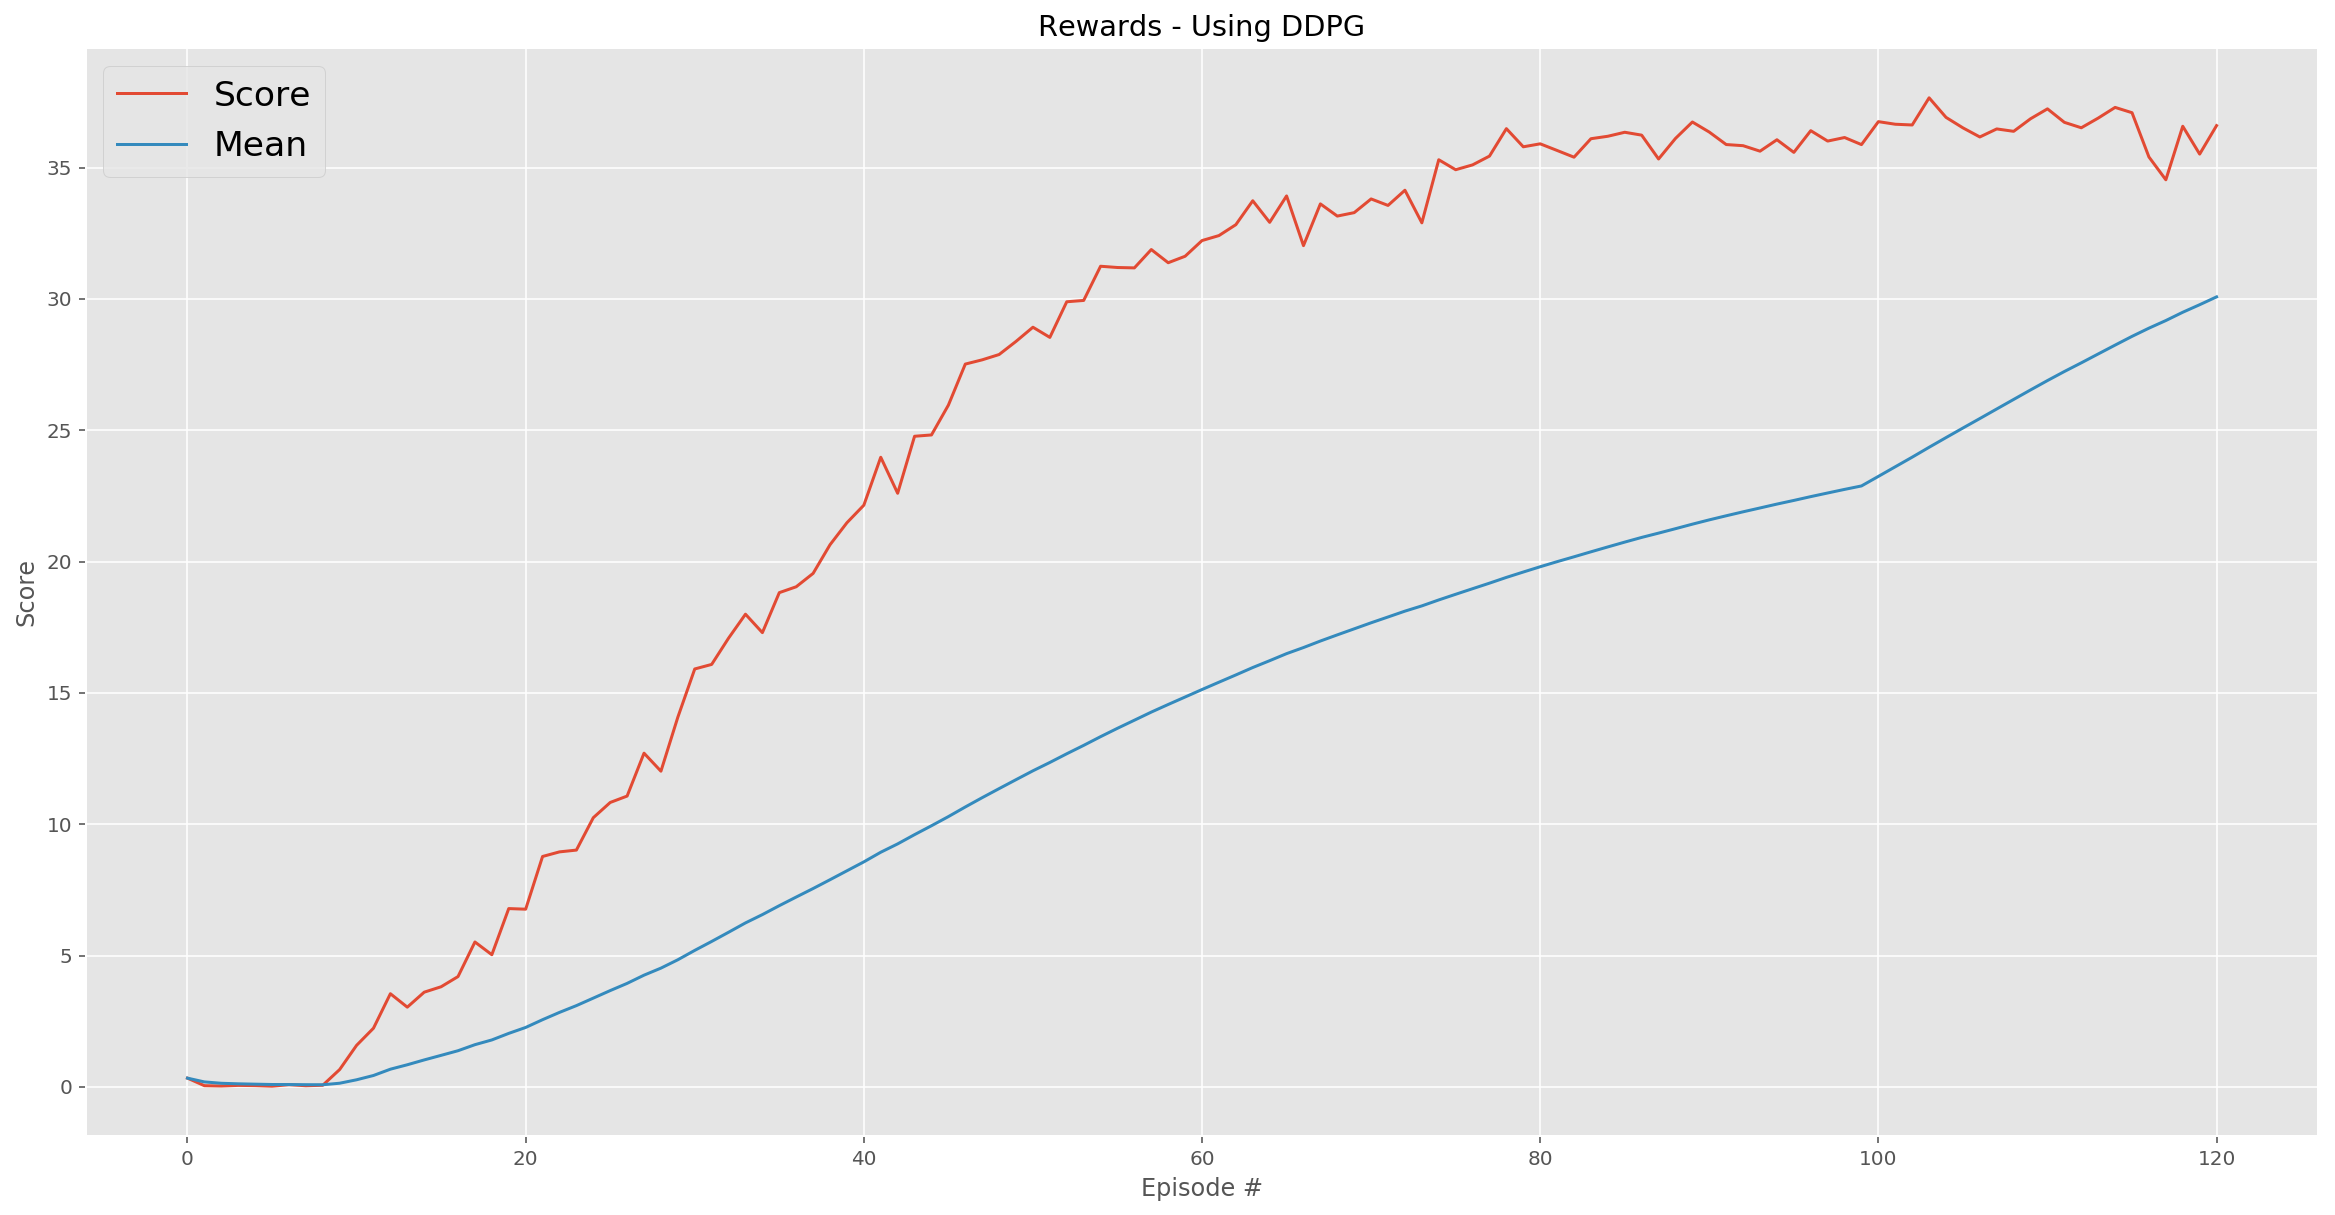

In [14]:
# Plot the scores using matplotlib.
plt.style.use('ggplot')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.title('Rewards - Using DDPG')
# plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(mean)), mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(('Score', 'Mean'), fontsize='xx-large')

# Reveal the plot.
plt.show()

#### Load the Saved Models

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

agent.actor_local.load_state_dict(torch.load('models/checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('models/checkpoint_critic.pth'))

In [11]:
def ddpg_train_mode_off(n_episodes=1, max_t=int(1e3)):
    """ Implementation of the Deep Deterministic Policy Gradient (DDPG) algorithm.
        See <https://spinningup.openai.com/en/latest/algorithms/ddpg.html>.
    
    Params
    ======
        n_episodes (int): Maximum number of training episodes
        max_t (int): Maximum number of time steps per episode
    """

    scores = []            # List containing scores from each episode.

    for i_episode in range(1, n_episodes+1):
        
        score = 0.                                           # Current score.
        env_info = env.reset(train_mode=False)[brain_name]   # Reset the environment.
        states = env_info.vector_observations                # Get the current state (for each agent).
        scores_window = np.zeros(num_agents)                 # Initialize the score (for each agent).
        agent.reset()                                        # Reset each agent (and noise).
        for step in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]          # Send all actions to tne environment.
            next_states = env_info.vector_observations        # Get next state (for each agent).
            rewards = env_info.rewards                        # Get reward (for each agent).
            states = next_states                              # Roll over states to next time step.
            dones = env_info.local_done                       # See if episode finished.
            agent.step(step, states, actions, rewards, next_states, dones)
            states = next_states
            scores_window += rewards
            if np.any(dones):                                # Exit loop if the episode finished.
                break
        score = np.mean(scores_window)                       # Save the most recent score.
        scores.append(score)
        print('\nEnvironment solved in {:d} episode.\tAverage score (μ): {:.2f}'.format(
            i_episode, score), end="\n")

    # Return the scores.
    return scores

#### Run the Agent Once

In [12]:
# Monitor training time (start time).
start_time = time.time()

# Run the agent.
scores = ddpg_train_mode_off()

# Monitor training time (end time).
end_time = (time.time()-start_time)/6e1

# Log the runtime.
print("\nTotal runtime {:.2f} minutes.".format(end_time))


Environment solved in 1 episode.	Average score (μ): 4.38

Total runtime 1.62 minutes.


#### We're Finished!

In [13]:
env.close()